# Eksploracja danych zbioru "German credit data"
Julia Kaznowska, Piotr Wilczyński <br>
06/03/2022 <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

### Import niezbędnych bibliotek oraz zbioru danych

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

# zbior danych
df_full = pd.read_csv("german_credit_data_dataset.csv")

# wyświetlanie wizualizacji
%matplotlib inline

### Podział zbioru danych na dane budujące i do walidacji

Zbiór zawiera dane kredytowe i klasyfikuje klientów na "złych" i "dobrych" do udzielenia kredytu, gdzie klient "zły", gdy z udzieleniem mu kredytu wiąże się duże ryzyko (kolumna <i>customer_type</i>). Podzielimy zbiór na dane do budowania i walidacji w proporcjach 70/30. Aby zachować odpowiednie proporcje w kolumnie <i>customer_type</i> użyjemy losowania warstowowego.

In [3]:
random.seed(123)
np.random.seed(123)
df_build_temp = df_full.groupby('customer_type', group_keys=False).apply(lambda x: x.sample(frac=0.7))
df_build_temp.sort_index(inplace = True)
df_validate = df_full[~df_full.index.isin(df_build_temp.index)]
print(df_validate.index)
print(df_build_temp.index)
print(df_build_temp['customer_type'].value_counts()[2]/df_build_temp['customer_type'].value_counts()[1])
print(df_validate['customer_type'].value_counts()[2]/df_validate['customer_type'].value_counts()[1])

Int64Index([  1,   3,   4,   5,  12,  14,  17,  22,  24,  25,
            ...
            966, 972, 974, 979, 982, 991, 993, 995, 997, 998],
           dtype='int64', length=300)
Int64Index([  0,   2,   6,   7,   8,   9,  10,  11,  13,  15,
            ...
            985, 986, 987, 988, 989, 990, 992, 994, 996, 999],
           dtype='int64', length=700)
0.42857142857142855
0.42857142857142855


Wiersze wydają się być podzielone prawidłowo. Podzielimy dane do budowania na kolejne dwie części docelowo po to, aby testować modele. My ogarniczemy się narazie do eksploracji danych zatem drugą cześć zbioru będziemy używać do sprawdzania wniosków.

In [4]:
df_build = df_build_temp.groupby('customer_type', group_keys=False).apply(lambda x: x.sample(frac=0.7))
df_build.sort_index(inplace = True)
df_test = df_build_temp[~df_build_temp.index.isin(df_build.index)]
print(df_test.index)
print(df_build.index)
print(df_build['customer_type'].value_counts()[2]/df_build['customer_type'].value_counts()[1])
print(df_test['customer_type'].value_counts()[2]/df_test['customer_type'].value_counts()[1])

Int64Index([  6,  10,  13,  18,  20,  27,  31,  32,  33,  34,
            ...
            945, 953, 962, 965, 976, 978, 980, 984, 985, 988],
           dtype='int64', length=210)
Int64Index([  0,   2,   7,   8,   9,  11,  15,  16,  19,  21,
            ...
            981, 983, 986, 987, 989, 990, 992, 994, 996, 999],
           dtype='int64', length=490)
0.42857142857142855
0.42857142857142855


Przygotujmy nowe ramki do pracy.

In [5]:
df_build.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)
df_validate.reset_index(drop = True, inplace = True)

### Opis kolumn

Zobaczmy kolumny zbioru i jakiego są typu:

In [6]:
df_build.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  490 non-null    object
 1   duration                 490 non-null    int64 
 2   credit_history           490 non-null    object
 3   purpose                  490 non-null    object
 4   credit_amount            490 non-null    int64 
 5   savings                  490 non-null    object
 6   present_employment       490 non-null    object
 7   installment_rate         490 non-null    int64 
 8   personal                 490 non-null    object
 9   other_debtors            490 non-null    object
 10  present_residence        490 non-null    int64 
 11  property                 490 non-null    object
 12  age                      490 non-null    int64 
 13  other_installment_plans  490 non-null    object
 14  housing                  490 non-null    o

Wyjaśnienie kolumn:
1. checking_account_status - Status istniejącego konta czekowego (A11: < 0 DM, A12: 0 <= x < 200 DM, A13 : >= 200 DM / cesja wynagrodzenia za co najmniej 1 rok, A14 : brak konta czekowego)
2. duration - Okres kredytu w miesiącach
3. credit_history - Historia kredytowa (A30: brak zaciągniętych kredytów/wszystkie kredyty spłacone należycie, A31: wszystkie kredyty w tym banku spłacone należycie, A32: istniejące kredyty spłacane należycie do tej pory, A33: opóźnienie w spłacie w przeszłości, A34 : krytyczne konto/inne kredyty zaciągnięte (nie w tym banku))
4. purpose - Cel kredytu (A40: samochód (nowy), A41: samochód (używany), A42: meble/wyposażenie, A43: radio/telewizja, A44: sprzęt AGD, A45: naprawy, A46: edukacja, A47: urlop, A48: przekwalifikowanie, A49: biznes, A410: inne) 
5. credit_amount - Suma kredytu
6. savings - Oszczędności na rachunkach/obligacjach (A61: < 100 DM, A62: 100 <= x < 500 DM, A63: 500 <= x < 1000 DM, A64: >= 1000 DM, A65: nieznane/ brak konta oszczędnościowego 
7. present_employment - Długość obecnego zatrudnienia. A71: bezrobotni, A72: < 1 rok, A73: 1 <= x < 4 lat, A74: 4 <= x < 7 lat, A75: .. >= 7 lat 
8. installment_rate - Stawka raty w procentach dochodu rozporządzalnego
9. personal - Osobisty stan cywilny i płeć (A91: mężczyzna rozwiedziony/w separacji, A92: kobieta rozwiedziona/w separacji/mężatka, A93: mężczyzna kawaler, A94: mężczyzna żonaty/wdowiec, A95: kobieta panna)
10. other_debtors - Inni dłużnicy (A101: brak, A102: współwnioskodawca, A103: poręczyciel)
11. present_residence - Obecne miejsce zamieszkania od
12. property - Własności (A121: nieruchomość, A122: jeśli nie A121 : umowa oszczędnościowa/ubezpieczenie na życie, A123: jeśli nie A121/A122 : samochód lub inny, nie w atrybucie 6, A124 : nieznane / brak nieruchomości) 
13. age - Wiek w latach
14. other_installment_plans - Inne plany ratalne (A141: banki, A142: sklepy, A143: brak)
15. housing - Zamieszkanie (A151: wynajem, A152: właściciel, A153: za darmo)
16. existing_credits - Liczba kredytów w innych bankach
17. job - Zatrudnienie (A171: bezrobotni/niewykwalifikowani - bez stałego miejsca zamieszkania, A172: niewykwalifikowani - stałe miejsce zamieszkania, A173: wykwalifikowany pracownik/urzędnik, A174: stanowisko kierownicze/samozatrudnienie, wysoko wykwalifikowany pracownik/funkcjonariusz)
18. dependents - Liczba osób, za które klient jest odpowiedzialny finansowo
19. telephone - (A191: brak, A192: tak, zarejestrowany na nazwisko klienta)
20. foreign_worker - Pracownik zagraniczny (A201: yes, A202: no )
21. customer_type - Rodzaj klienta (1 - dobry (niskiego ryzka), 2 - zły (wysokiego ryzyka))

Zobaczmy pierwsze rekordy ramki

In [7]:
df_build.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
2,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
3,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
4,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


Podzielmy kolumny na numeryczne i kategoryczne

In [8]:
df_build.apply(lambda x: len(x.unique()))

checking_account_status      4
duration                    27
credit_history               5
purpose                     10
credit_amount              470
savings                      5
present_employment           5
installment_rate             4
personal                     4
other_debtors                3
present_residence            4
property                     4
age                         49
other_installment_plans      3
housing                      3
existing_credits             4
job                          4
dependents                   2
telephone                    2
foreign_worker               2
customer_type                2
dtype: int64

Zatem zmienne <i>duration</i>, <i>credit_amount</i>, <i>age</i> są numeryczne, resztę można uznać za kategoryczne. 

In [9]:
numeric_columns = np.array(["duration", "credit_amount", "age"])
nominal_columns = df_build.columns.values
nominal_columns = np.delete(nominal_columns, [1, 4, 12])

oraz podstawowe cechy zmiennych numerycznych.

In [10]:
df_build[numeric_columns].describe()

,duration,credit_amount,age
count,490.000000,490.00000,490.000000
mean,20.734694,3293.70000,35.653061
std,12.225347,2867.67057,11.102517
min,4.000000,250.00000,20.000000
25%,12.000000,1361.75000,27.000000
50%,18.000000,2363.00000,33.000000
75%,24.000000,4033.00000,42.000000
max,60.000000,18424.00000,75.000000


### Braki danych

Na stronie, z której pochodzi zbiór danych jest informacja, że numeryczne braki danych są oznaczone "-100000", a nominalne "?".

In [11]:
"?" in df_build.apply(lambda x: x.value_counts()).index

False

In [12]:
"-100000" in df_build.apply(lambda x: x.value_counts()).index

False

In [13]:
df_build.apply(lambda x: x.isna().sum(), axis=0)

checking_account_status    0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
present_employment         0
installment_rate           0
personal                   0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
customer_type              0
dtype: int64

Wydaje się, że w ramce nie ma żadnych nulli.

### Wstępna analiza danych

Do wstępnej analizy danych będziemy używać raportu pakietu Pandas-profiling.

In [14]:
profile = ProfileReport(df_build, title = "German credit data - Exploratory Data Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Jednowymiarowa analiza zmiennych

Podzielmy kolumny na numeryczne i kategoryczne

In [120]:
df_build.apply(lambda x: len(x.unique()))

checking_account_status      4
duration                    27
credit_history               5
purpose                     10
credit_amount              470
savings                      5
present_employment           5
installment_rate             4
personal                     4
other_debtors                3
present_residence            4
property                     4
age                         49
other_installment_plans      3
housing                      3
existing_credits             4
job                          4
dependents                   2
telephone                    2
foreign_worker               2
customer_type                2
dtype: int64

Zatem zmienne <i>duration</i>, <i>credit_amount</i>, <i>age</i> są numeryczne, resztę można uznać za kategoryczne. 

In [150]:

numeric_columns = np.array(["duration", "credit_amount", "age"])
nominal_columns = df_build.columns.values
nominal_columns = np.delete(nominal_columns, [1, 4, 12])

#### Zmienne numeryczne

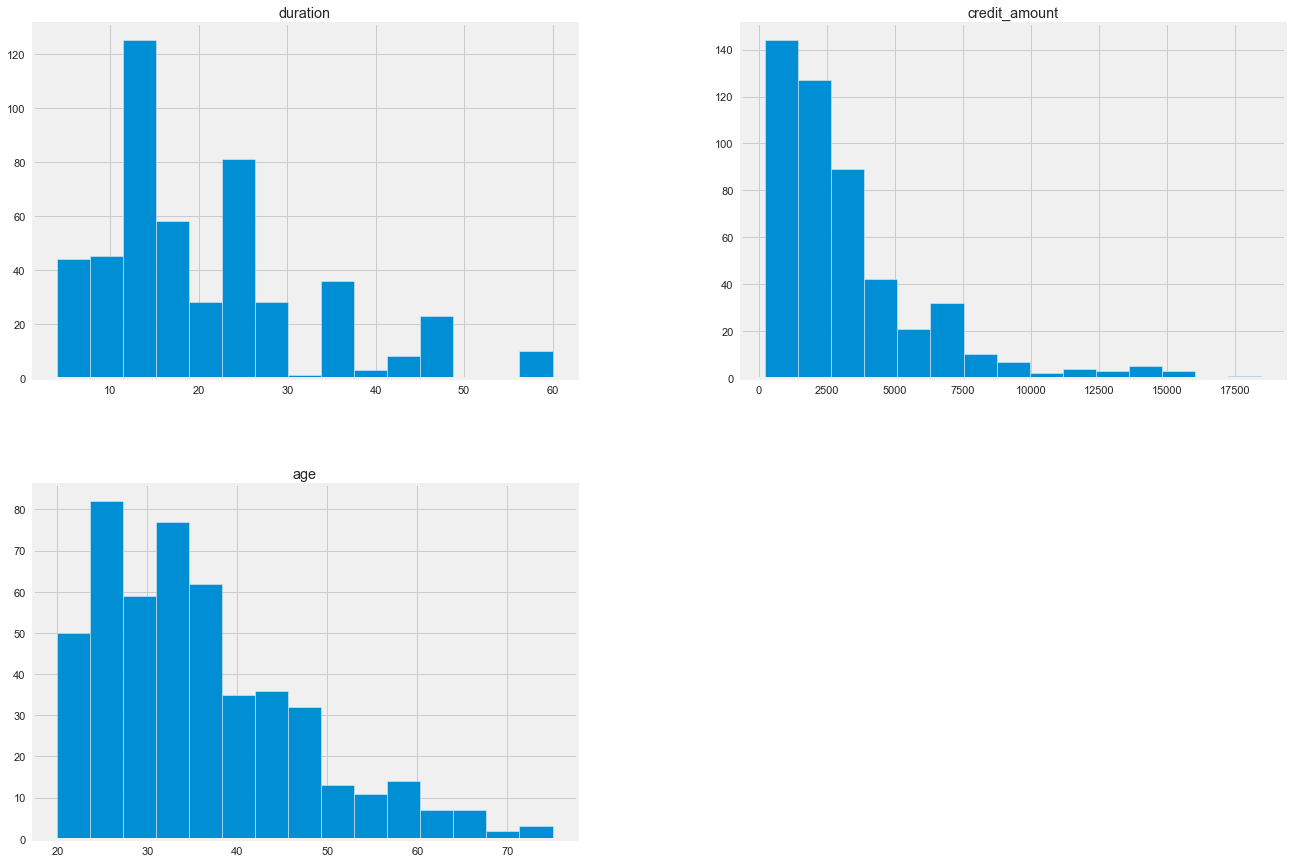

In [167]:
df_build.hist(column = numeric_columns, figsize = [20, 15], bins = 15)
plt.show()

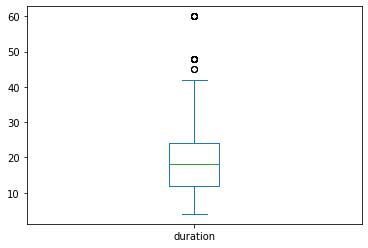

In [23]:
df_build["duration"].plot(kind = "box")
plt.show()

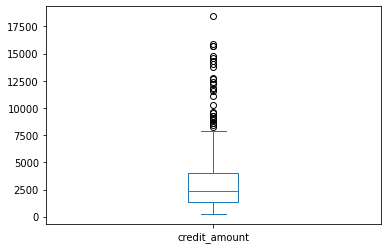

In [25]:
df_build["credit_amount"].plot(kind = "box")
plt.show()

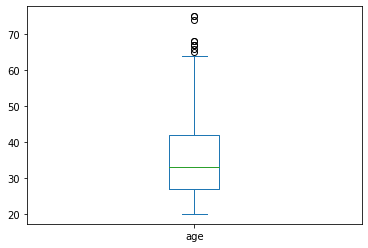

In [24]:
df_build["age"].plot(kind = "box")
plt.show()

#### Zmienne kategoryczne

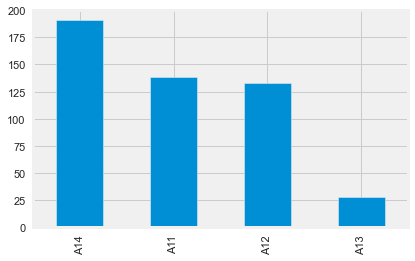

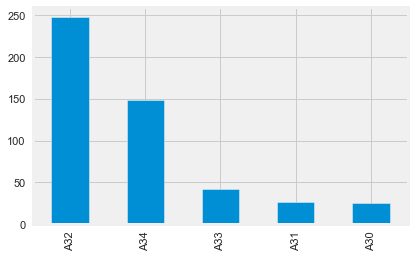

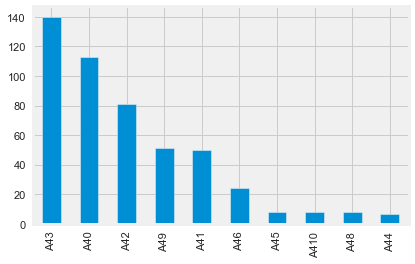

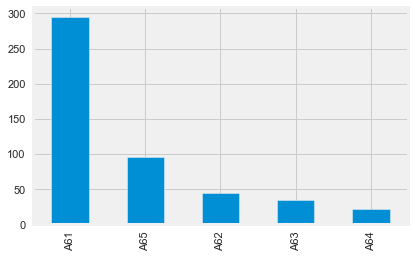

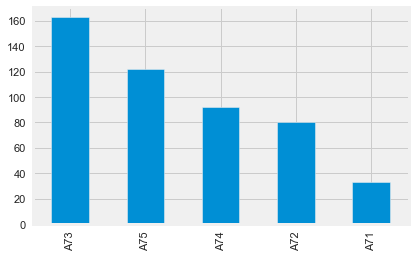

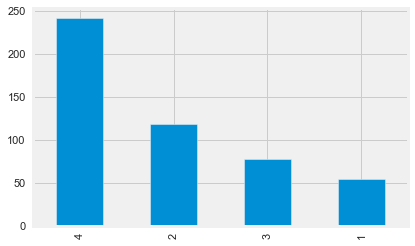

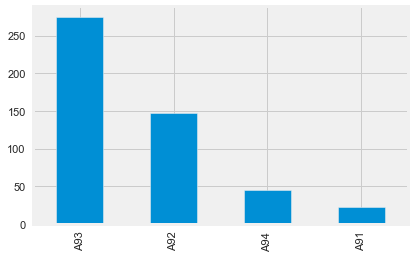

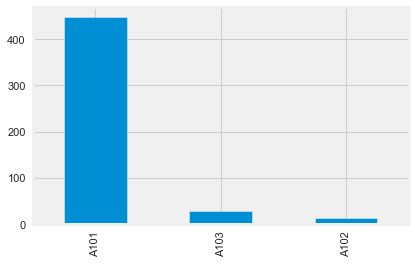

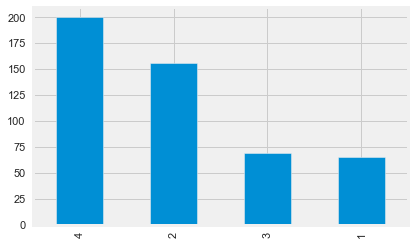

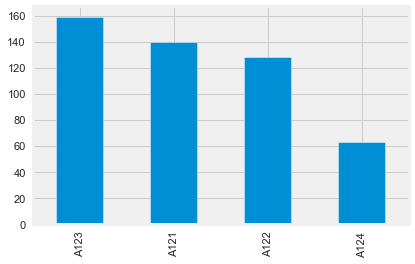

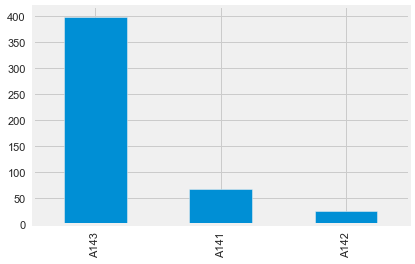

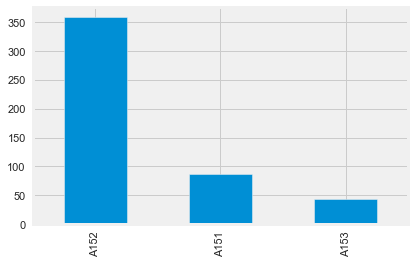

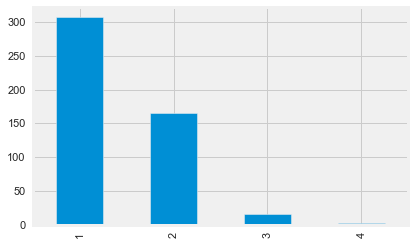

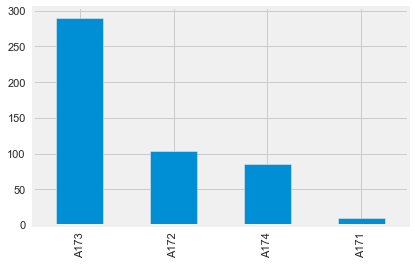

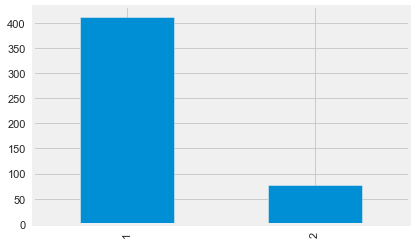

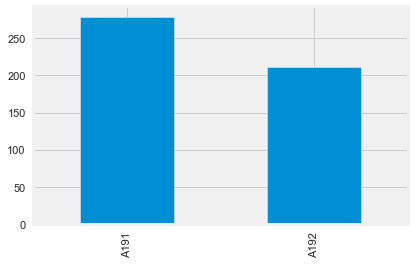

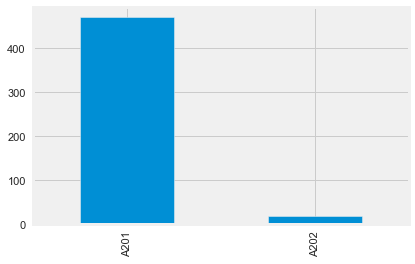

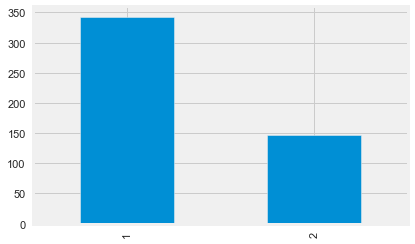

In [168]:
for col in nominal_columns:
    df_build[col].value_counts().plot(kind = "bar")
    plt.show()
